<a href="https://colab.research.google.com/github/langfordzd/bursts-cc-pt/blob/main/parameter_picks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# First we need to install and import a few things



In [1]:
!pip install neurodsp
!pip install bycycle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 88 kB 2.7 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 62 kB 1.2 MB/s 


In [2]:
import matplotlib.pyplot as plt
import numpy as np
from bycycle.features import compute_features
from neurodsp.sim import sim_powerlaw
from neurodsp.utils import set_random_seed
import itertools
from multiprocessing import Pool, cpu_count      
import pandas as pd
import seaborn as sns
from neurodsp.sim import sim_oscillation
from neurodsp.timefrequency import amp_by_time
from scipy import stats
import matplotlib as mpl
import matplotlib.gridspec as gridspec
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['font.size'] = 18

In [ ]:
def f_cf(signal,thresh):
    
    threshold_kwargs = {'amp_fraction_threshold': 0.0, 
                   'amp_consistency_threshold': thresh[0],
                   'period_consistency_threshold': thresh[1],
                   'monotonicity_threshold': thresh[2],
                   'min_n_cycles': thresh[3]}
    
    sf = compute_features(signal[1], s_rate, 
                              (15,29), threshold_kwargs=threshold_kwargs,
                              return_samples=True)
    count = 0
    bursts = sf[sf['is_burst']]         
    if any(bursts['is_burst']):
        burst_list = np.split(bursts, np.flatnonzero(np.diff(bursts.index) != 1) + 1)
        count = len(burst_list)
        
    return count

In [ ]:
#%% THIS WILL TAKE A LONG TIME
set_random_seed(1)
n_noises = 100
secs = 1
s_rate = 250
threshs = np.around(np.arange(0.2,0.8+0.1,0.2),3).tolist()
wte = list(itertools.product(threshs, repeat= 3))   
wte2 = [e + tuple([2]) for e in wte]
wte3 = [e + tuple([3]) for e in wte]
wte = wte2+wte3
signals = [(i,sim_powerlaw(secs, s_rate, exponent=-2)) for i in range(0,n_noises)]
sig_eval_product = list(itertools.product(signals, wte))
num_cores = cpu_count()
pool = Pool(processes=num_cores)
result =  pool.starmap(f_cf, sig_eval_product)
pool.close()
pool.join()  

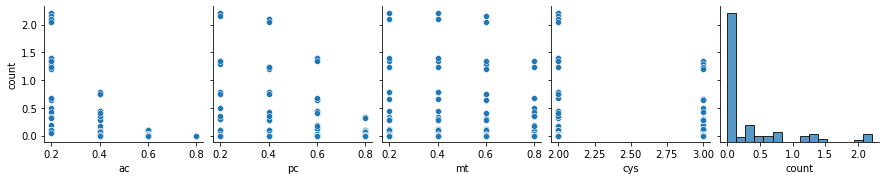

In [ ]:
wte_map = [x[1] for x in sig_eval_product]
num_map = [x[0][0] for x in sig_eval_product]
answer = [tuple([b])+e for b,e in zip(result,wte_map)]
t = pd.DataFrame(answer,columns=['count', 'ac', 'pc', 'mt','cys'])
t['noise'] = num_map
rands = 1000 #times to randomize
exp_size = 10 #trials
ss = []
import random
for _ in range(rands):
    rs = random.sample(range(0, n_noises), exp_size)
    selec = t.loc[t['noise'].isin(rs)]
    ss_ = pd.DataFrame(selec.groupby(['ac', 'pc', 'mt','cys'],as_index=False)['count'].mean())
    ss.append(ss_)

t = pd.concat(ss)
a = pd.DataFrame(t.groupby(['ac', 'pc', 'mt','cys'],as_index=False)['count'].mean())
sns.pairplot(a, y_vars="count", x_vars=a.columns.values)

In [ ]:
import plotly.express as pex

my_plot = pex.scatter_3d(a, x='ac',y='pc',z='mt',color='count')
my_plot.show()

# How to chose amongst our parameters?

(0.9893542246182561, 0.0)


Text(4000, 0.5, '-0.18')

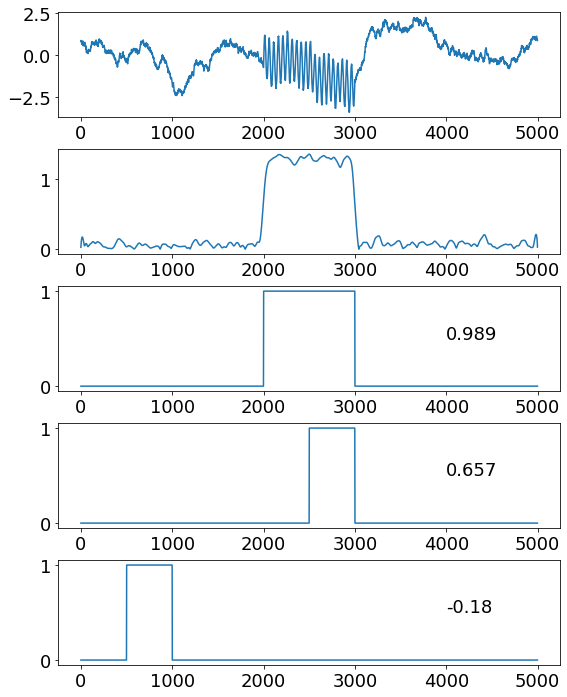

In [3]:
osc = sim_oscillation(n_seconds=1, fs=1000, freq=20,phase=0)
noise = sim_powerlaw(n_seconds=5, fs=1000)
sig = np.pad(osc, (2000, 2000), 'constant', constant_values=(0))
signal = sig+noise
amp = amp_by_time(signal,fs=1000,f_range=(15, 29),remove_edges=False)
w = np.ones(1000)
b1 = np.pad(w, (2000, 2000), 'constant', constant_values=(0))
w = np.ones(500)
b2 = np.pad(w, (2500, 2000), 'constant', constant_values=(0))
w = np.ones(500)
b3 = np.pad(w, (500, 4000), 'constant', constant_values=(0))

fig = plt.figure(1, figsize=(9, 12))
gs = gridspec.GridSpec(10, 2)
gs.update(wspace=0.7, hspace=0.9)
xtr = fig.add_subplot(gs[0:2, 0:2])
xtr.plot(signal)
xtr = fig.add_subplot(gs[2:4, 0:2])
xtr.plot(amp)
xtr = fig.add_subplot(gs[4:6, 0:2])
xtr.plot(b1)
xtr.annotate(str(stats.pearsonr(b1, amp)[0])[:5],xy=(4000,0.5))
print(stats.pearsonr(b1, amp))
xtr = fig.add_subplot(gs[6:8, 0:2])
xtr.plot(b2)
xtr.annotate(str(stats.pearsonr(b2, amp)[0])[:5],xy=(4000,0.5))
xtr = fig.add_subplot(gs[8:10, 0:2])
xtr.plot(b3)
xtr.annotate(str(stats.pearsonr(b3, amp)[0])[:5],xy=(4000,0.5))